# Mason's workbook on zestimate log errors

##### Due: 2022.01.07

In [1]:
#learn gong fu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mason_functions as mf
import scaler as sc
import wrangle_bits as wb
import sklearn.preprocessing

import env
import os
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE

## Plan

## Wrangle

In [2]:
#define my sql query
sql = '''
SELECT *
FROM properties_2017
LEFT JOIN predictions_2017 pred USING(parcelid)
LEFT JOIN airconditioningtype USING(airconditioningtypeid)
LEFT JOIN architecturalstyletype USING(architecturalstyletypeid)
LEFT JOIN buildingclasstype USING(buildingclasstypeid)
LEFT JOIN heatingorsystemtype USING(heatingorsystemtypeid)
LEFT JOIN propertylandusetype USING(propertylandusetypeid)
LEFT JOIN storytype USING(storytypeid)
LEFT JOIN typeconstructiontype USING(typeconstructiontypeid)
WHERE latitude IS NOT NULL 
AND longitude IS NOT NULL
AND propertylandusetypeid = 261
AND transactiondate LIKE "2017%%"
AND pred.id IN (SELECT MAX(id)
FROM predictions_2017
GROUP BY parcelid
HAVING MAX(transactiondate))
'''

#define my url
url = mf.get_db_url('zillow')

#set up an if-conditional to see if there is a .csv readily available, then load the data
if os.path.isfile('zillow_ol_pal.csv'):
    df = pd.read_csv('zillow_ol_pal.csv', index_col = 0)
else:
    df = pd.read_sql(sql, url)
    df.to_csv('zillow_ol_pal.csv')

In [3]:
pd.options.display.max_columns = 69
pd.options.display.max_rows = 69

In [4]:
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14297519,1727539,NaN,3.5,4.0,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,1.0,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17052889,1387261,NaN,1.0,2.0,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14186244,11677,NaN,2.0,3.0,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,12177905,2288172,NaN,3.0,4.0,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,NaN,NaN,261.0,2.0,NaN,NaN,1.0,12095076,781532,NaN,3.0,4.0,9.0,3.0,NaN,NaN,2962.0,2962.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,34145202.0,-118179824.0,63000.0,1.0,NaN,NaN,NaN,1.0,0101,PSR2,6.037461e+07,47019.0,3101.0,274684.0,96293.0,0.0,NaN,1.0,NaN,NaN,1950.0,NaN,NaN,276684.0,773303.0,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,6,-0.001011,2017-01-01,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52318
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   storytypeid                   47 non-null     float64
 2   propertylandusetypeid         52319 non-null  float64
 3   heatingorsystemtypeid         33849 non-null  float64
 4   buildingclasstypeid           0 non-null      float64
 5   architecturalstyletypeid      70 non-null     float64
 6   airconditioningtypeid         13615 non-null  float64
 7   parcelid                      52319 non-null  int64  
 8   id                            52319 non-null  int64  
 9   basementsqft                  47 non-null     float64
 10  bathroomcnt                   52319 non-null  float64
 11  bedroomcnt                    52319 non-null  float64
 12  buildingqualitytypeid         33654 non-null  float64
 13  c

In [6]:
#verify length of dataframe is the same as the number of unique parcel ids
df.parcelid.nunique()

52319

In [7]:
#calculate column nulls
column_nulls = wb.calculate_column_nulls(df)

In [8]:
#column nulls at a glance
column_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
finishedsquarefeet13,52319,1.00000,100.0%
buildingclassdesc,52319,1.00000,100.0%
buildingclasstypeid,52319,1.00000,100.0%
finishedsquarefeet15,52319,1.00000,100.0%
storydesc,52272,0.99910,99.91%
storytypeid,52272,0.99910,99.91%
basementsqft,52272,0.99910,99.91%
yardbuildingsqft26,52256,0.99880,99.88%
architecturalstyletypeid,52249,0.99866,99.87%
architecturalstyledesc,52249,0.99866,99.87%


In [9]:
#calculate row nulls
row_nulls = wb.calculate_row_nulls(df)

In [10]:
#row nulls at a glance
row_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
28006,48,0.69565,70%
8954,48,0.69565,70%
41347,47,0.68116,68%
13356,46,0.66667,67%
21989,45,0.65217,65%
...,...,...,...
44684,24,0.34783,35%
83,24,0.34783,35%
37444,24,0.34783,35%
39391,23,0.33333,33%


In [11]:
#handle missing nulls 
#(drop any column with over half of the values missing and any rows with over half missing after dropping columns)
df = wb.handle_nulls(df, .5 , .5)

In [12]:
#calculate remaining column nulls
column_nulls = wb.calculate_column_nulls(df)

In [13]:
#remaining column nulls at a glance
column_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
buildingqualitytypeid,18665,0.35675,35.68%
unitcnt,18558,0.35471,35.47%
propertyzoningdesc,18558,0.35471,35.47%
heatingorsystemdesc,18470,0.35303,35.3%
heatingorsystemtypeid,18470,0.35303,35.3%
regionidcity,1036,0.01980,1.98%
lotsizesquarefeet,366,0.00700,0.7%
finishedsquarefeet12,246,0.00470,0.47%
fullbathcnt,135,0.00258,0.26%
calculatedbathnbr,135,0.00258,0.26%


In [14]:
#calculate remaining row nulls
row_nulls = wb.calculate_row_nulls(df)

In [15]:
#remaining row nulls at a glance
row_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
28006,14,0.40000,40%
8954,14,0.40000,40%
41347,13,0.37143,37%
48475,12,0.34286,34%
32311,12,0.34286,34%
...,...,...,...
21482,0,0.00000,0%
21483,0,0.00000,0%
21484,0,0.00000,0%
21486,0,0.00000,0%


In [16]:
#set an empty list
okay_to_drop = []

#commence loop through index of column nulls
for n in range(len(column_nulls)):
    
    #set up conditional to see if ratio of values missing in column is less than 2%
    if column_nulls.iloc[n].null_ratio < .2:
        
        #add features to list 
        okay_to_drop.append(column_nulls.index[n])
        
#verify
#print(okay_to_drop)

#commence loop through list        
for feature in okay_to_drop:
    
    #drop rows where there are missing values in the columns specified
    df = df[df[feature].notnull()]

In [17]:
#calculate remaining nulls
column_nulls = wb.calculate_column_nulls(df)

In [18]:
#pull up the list of column nulls to verify dropped rows
column_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
buildingqualitytypeid,17939,0.35481,35.48%
propertyzoningdesc,17873,0.35351,35.35%
unitcnt,17856,0.35317,35.32%
heatingorsystemdesc,17764,0.35135,35.14%
heatingorsystemtypeid,17764,0.35135,35.14%
propertylandusetypeid,0,0.00000,0.0%
taxvaluedollarcnt,0,0.00000,0.0%
roomcnt,0,0.00000,0.0%
yearbuilt,0,0.00000,0.0%
structuretaxvaluedollarcnt,0,0.00000,0.0%


What is propertyzoningdesc? There is no corresponding table

In [19]:
#pull up values for propertyzoningdesc column
df.propertyzoningdesc.value_counts(dropna = False)

NaN           17873
LAR1           6404
LARS           1378
LBR1N          1107
SCUR2           611
              ...  
LCRAVV            1
DOR3*             1
RMPD*             1
WAR110000*        1
GDE4*             1
Name: propertyzoningdesc, Length: 1237, dtype: int64

In [20]:
#create final list of columns to drop
final_drops = []

In [21]:
#add column to list
final_drops.append('propertyzoningdesc')

In [22]:
#pull up values for heatingsystemdesc
df.heatingorsystemdesc.value_counts(dropna = False)

Central       19897
NaN           17764
Floor/Wall    12330
Forced air      502
Solar            36
None             16
Baseboard         7
Radiant           4
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

Okay, I'll come back for this

In [23]:
#pull up values for unitcnt
df.unitcnt.value_counts(dropna = False)

1.0    32684
NaN    17856
2.0       18
3.0        1
Name: unitcnt, dtype: int64

In [24]:
#map null values to the value of 1
df.unitcnt = df.unitcnt.map({np.nan: 1,
               1: 1,
               2: 2,
               3: 3})

In [25]:
#verify
df.unitcnt.value_counts(dropna = False)

1    50540
2       18
3        1
Name: unitcnt, dtype: int64

In [26]:
#pull up values for buildingqualitytypeid
df.buildingqualitytypeid.value_counts(dropna = False).sort_index(ascending = False)

12.0       76
11.0      482
10.0      211
9.0      1035
8.0      7981
7.0      3125
6.0     10125
5.0      1469
4.0      7967
3.0       141
2.0         4
1.0         4
NaN     17939
Name: buildingqualitytypeid, dtype: int64

There is nothing in the database that I see that helps me identify what kind of feature this is. Drop

In [27]:
#add to the list of final drops
final_drops.append('buildingqualitytypeid')

In [28]:
#drop columns on list
df = df.drop(columns = final_drops)

In [29]:
#calculate remaining column nulls
column_nulls = wb.calculate_column_nulls(df)

In [30]:
#a look at what's left
column_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
heatingorsystemtypeid,17764,0.35135,35.14%
heatingorsystemdesc,17764,0.35135,35.14%
assessmentyear,0,0.00000,0.0%
regionidzip,0,0.00000,0.0%
roomcnt,0,0.00000,0.0%
unitcnt,0,0.00000,0.0%
yearbuilt,0,0.00000,0.0%
structuretaxvaluedollarcnt,0,0.00000,0.0%
taxvaluedollarcnt,0,0.00000,0.0%
propertylandusetypeid,0,0.00000,0.0%


In [31]:
#verify length of columns nulls dataframe
len(column_nulls)

33

In [32]:
#drop nulls for now
df = df[df.heatingorsystemtypeid.notnull()]
df = df[df.heatingorsystemdesc.notnull()]

In [33]:
#value counts for heatingorsystemtypeid
df.heatingorsystemtypeid.value_counts(dropna = False).sort_index()

1.0         7
2.0     19897
6.0       502
7.0     12330
10.0        2
13.0       16
18.0        4
20.0       36
24.0        1
Name: heatingorsystemtypeid, dtype: int64

In [34]:
#get rid of value that only has 1 count (corresponding value for type id 24 is 'Yes')
df = df[df.heatingorsystemtypeid != 24]

In [35]:
#import feature selection functions
import explore_bits as eb

In [36]:
#check dataframe for features to get hunches on what drives heating system type
df.head()

,propertylandusetypeid,heatingorsystemtypeid,parcelid,id,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id.1,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
3,261.0,2.0,12177905,2288172,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,3,-0.103410,2017-01-01,Central,Single Family Residential
4,261.0,2.0,12095076,781532,3.0,4.0,3.0,2962.0,2962.0,6037.0,3.0,34145202.0,-118179824.0,63000.0,0101,6.037461e+07,47019.0,3101.0,96293.0,0.0,1,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,6,-0.001011,2017-01-01,Central,Single Family Residential
6,261.0,2.0,12790562,1246926,3.0,4.0,3.0,3039.0,3039.0,6037.0,3.0,33960230.0,-118006914.0,20028.0,0100,6.037500e+07,14634.0,3101.0,96173.0,0.0,1,1970.0,177527.0,220583.0,2016.0,43056.0,3104.19,6.037500e+13,8,-0.040966,2017-01-02,Central,Single Family Residential
7,261.0,2.0,11104527,1639362,3.0,4.0,3.0,2540.0,2540.0,6037.0,3.0,34434971.0,-118464390.0,10384.0,0101,6.037920e+07,54311.0,3101.0,96374.0,0.0,1,1999.0,271715.0,430108.0,2016.0,158393.0,6103.36,6.037920e+13,10,0.005963,2017-01-02,Central,Single Family Residential
11,261.0,7.0,11830315,571930,1.0,2.0,1.0,1146.0,1146.0,6037.0,1.0,34024040.0,-118159090.0,4657.0,0100,6.037532e+07,17882.0,3101.0,96003.0,0.0,1,1939.0,127960.0,273745.0,2016.0,145785.0,3739.02,6.037532e+13,18,-0.035085,2017-01-02,Floor/Wall,Single Family Residential


In [37]:
#pull up df info to check column info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32794 entries, 3 to 52318
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         32794 non-null  float64
 1   heatingorsystemtypeid         32794 non-null  float64
 2   parcelid                      32794 non-null  int64  
 3   id                            32794 non-null  int64  
 4   bathroomcnt                   32794 non-null  float64
 5   bedroomcnt                    32794 non-null  float64
 6   calculatedbathnbr             32794 non-null  float64
 7   calculatedfinishedsquarefeet  32794 non-null  float64
 8   finishedsquarefeet12          32794 non-null  float64
 9   fips                          32794 non-null  float64
 10  fullbathcnt                   32794 non-null  float64
 11  latitude                      32794 non-null  float64
 12  longitude                     32794 non-null  float64
 13  l

In [38]:
#pull up values for property land use codes
df.propertycountylandusecode.value_counts()

0100    25479
0101     6135
122       555
0104      355
0103       84
010G       65
0108       52
010M       41
0113        6
0110        5
0109        5
0102        3
0105        2
0111        2
0114        1
0131        1
0130        1
1           1
0133        1
Name: propertycountylandusecode, dtype: int64

In [39]:
#age as a continuous variable makes more sense
df['age'] = 2017 - df['yearbuilt']

In [40]:
#add all of the features to the drop list that don't seem like they would be drivers for heating system type
quick_drop = ['assessmentyear', 'yearbuilt', 'transactiondate', 'heatingorsystemdesc', 'propertylandusedesc', 'propertycountylandusecode', 'id', 'regionidcounty', 'regionidcity', 'regionidzip', 'regionidzip', 'logerror', 'censustractandblock', 'rawcensustractandblock', 'id.1', 'finishedsquarefeet12', 'latitude', 'longitude', 'fips']
df = df.drop(columns = quick_drop)

In [41]:
#set the index to parcel id because we really don't need this as a feature
df = df.set_index('parcelid')

In [42]:
#check my columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32794 entries, 12177905 to 12826780
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         32794 non-null  float64
 1   heatingorsystemtypeid         32794 non-null  float64
 2   bathroomcnt                   32794 non-null  float64
 3   bedroomcnt                    32794 non-null  float64
 4   calculatedbathnbr             32794 non-null  float64
 5   calculatedfinishedsquarefeet  32794 non-null  float64
 6   fullbathcnt                   32794 non-null  float64
 7   lotsizesquarefeet             32794 non-null  float64
 8   roomcnt                       32794 non-null  float64
 9   unitcnt                       32794 non-null  int64  
 10  structuretaxvaluedollarcnt    32794 non-null  float64
 11  taxvaluedollarcnt             32794 non-null  float64
 12  landtaxvaluedollarcnt         32794 non-null  floa

In [43]:
#assign dataframe columns to a list
df_columns = df.columns.to_list()

In [44]:
#loop through the list of columns
for col in df_columns:

    q1, q3 = df[col].quantile([.25, .75])  # get quartiles
    
    iqr = q3 - q1   # calculate interquartile range
    
    upper_bound = q3 + 1 * iqr   # get upper bound
    lower_bound = q1 - 1 * iqr   # get lower bound
    
    dft = df[(df[col] > lower_bound) & (df[col] < upper_bound)] # return dataframe without outliers

In [45]:
#double check that outliers were removed
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25917 entries, 12177905 to 12826780
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         25917 non-null  float64
 1   heatingorsystemtypeid         25917 non-null  float64
 2   bathroomcnt                   25917 non-null  float64
 3   bedroomcnt                    25917 non-null  float64
 4   calculatedbathnbr             25917 non-null  float64
 5   calculatedfinishedsquarefeet  25917 non-null  float64
 6   fullbathcnt                   25917 non-null  float64
 7   lotsizesquarefeet             25917 non-null  float64
 8   roomcnt                       25917 non-null  float64
 9   unitcnt                       25917 non-null  int64  
 10  structuretaxvaluedollarcnt    25917 non-null  float64
 11  taxvaluedollarcnt             25917 non-null  float64
 12  landtaxvaluedollarcnt         25917 non-null  floa

In [46]:
#keep things normal
df = dft

In [47]:
#get a list of numerical columns 
quant_vars = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'unitcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'lotsizesquarefeet', 'roomcnt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'age']

In [48]:
#measure length of the list
len(quant_vars)

13

In [49]:
#split it
train, validate, test = wb.split_data(df, target = 'heatingorsystemtypeid')

In [50]:
#scale the data
train_scaled, validate_scaled, test_scaled, scaler = sc.robust_scaler(train, validate, test, quant_vars)

In [51]:
#preview scaled training set data
train_scaled.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,unitcnt,calculatedfinishedsquarefeet,fullbathcnt,lotsizesquarefeet,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,age
parcelid,,,,,,,,,,,,,
11982457,2.0,1.0,2.0,0.0,1.167085,2.0,-1.074751,0.0,-0.265865,-0.469776,-0.428400,-0.510503,1.071429
11101213,0.0,0.0,0.0,0.0,-0.443467,0.0,0.241258,0.0,-0.673217,-0.693338,-0.556103,-0.771820,-0.285714
11453719,1.0,1.0,1.0,0.0,1.566583,1.0,0.726981,0.0,1.661353,1.356174,1.126311,1.404554,-0.714286
12135483,0.0,0.0,0.0,0.0,0.288945,0.0,0.955406,0.0,-0.052500,0.064100,0.154153,0.042420,0.642857
10790521,0.0,0.0,0.0,0.0,0.368090,0.0,0.186718,0.0,-0.523187,-0.640193,-0.545190,-0.706868,-0.142857


In [52]:
#juxtapose data set shapes
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((14513, 13), (6220, 13), (5184, 13))

In [53]:
#set up modeling data
X_train = train_scaled
y_train = train.heatingorsystemtypeid

X_validate = validate_scaled
y_validate = validate.heatingorsystemtypeid

X_test = test_scaled
y_test = test.heatingorsystemtypeid

In [54]:
#juxtapose shape of X_train and X_validate
X_train.shape, X_validate.shape

((14513, 13), (6220, 13))

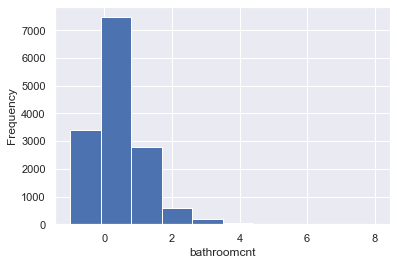

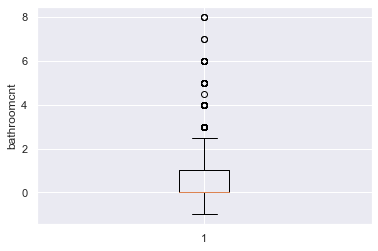

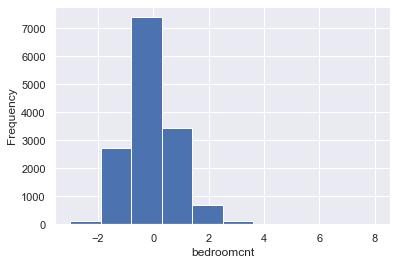

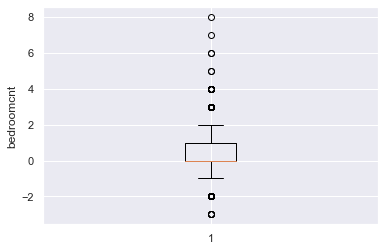

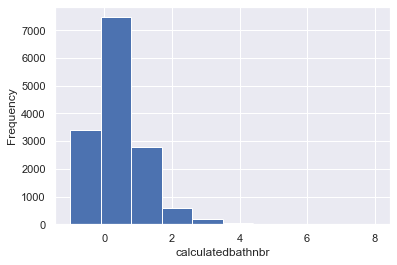

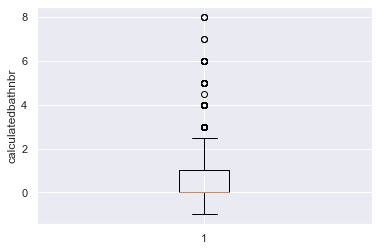

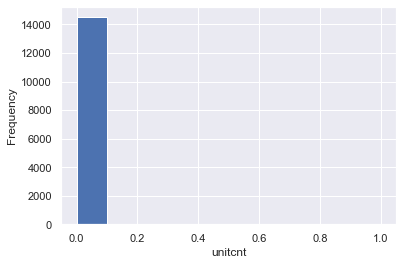

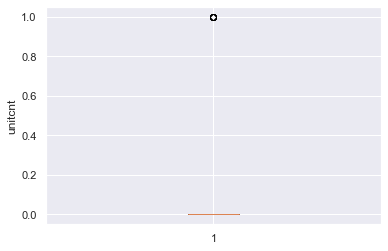

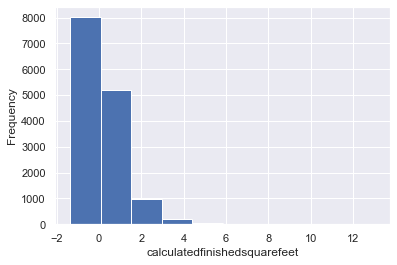

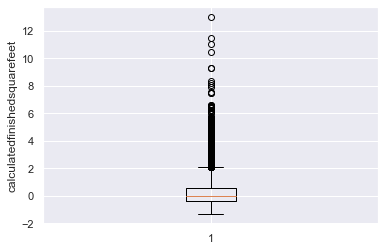

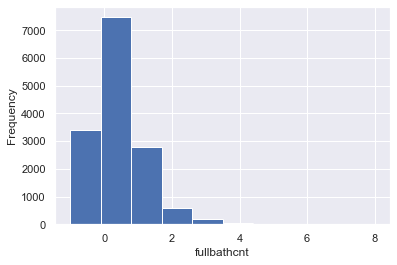

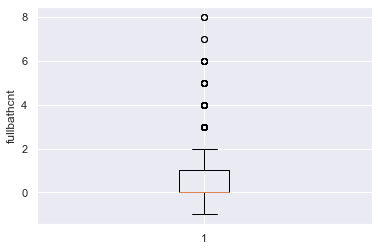

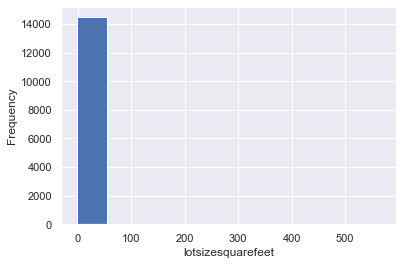

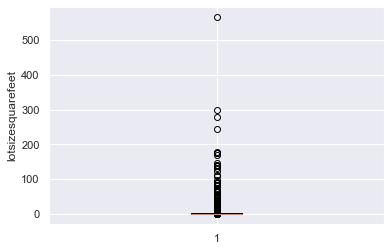

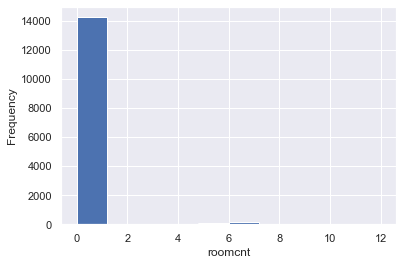

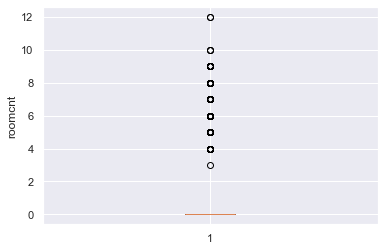

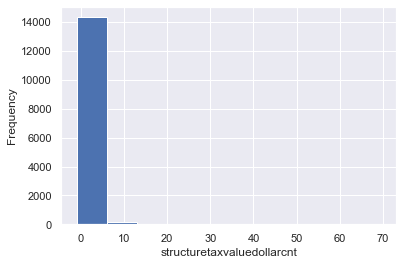

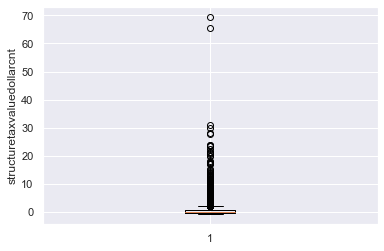

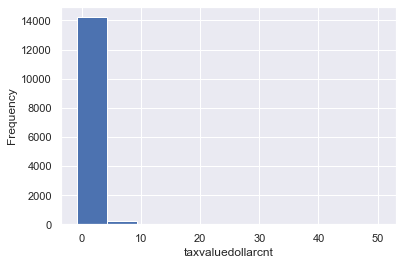

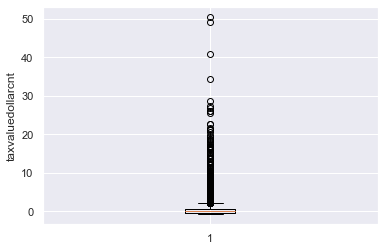

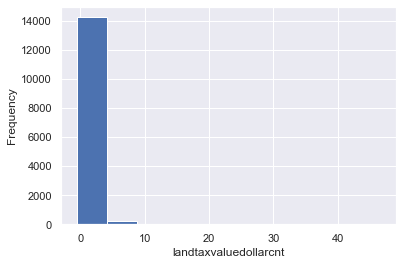

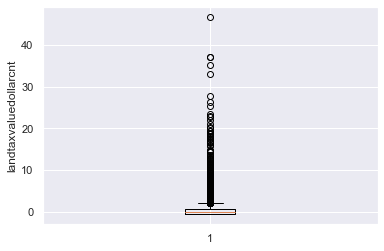

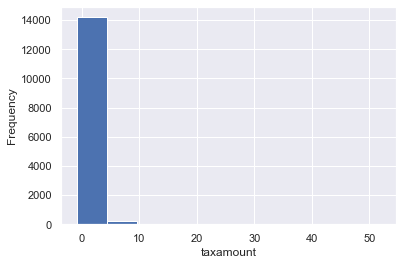

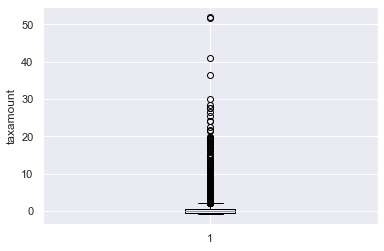

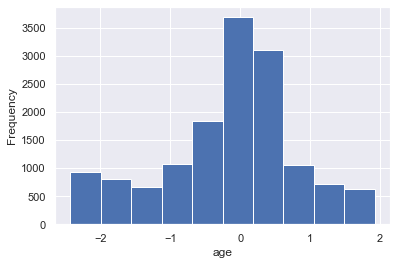

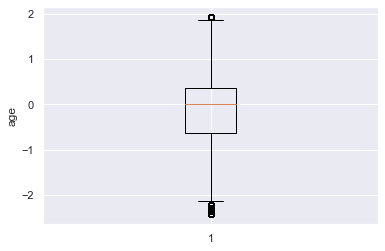

In [55]:
#get list
train_columns = train_scaled.columns.to_list()

#loop through this list to view distributions of numeric columns
for cat in quant_vars:
    train_scaled[cat].hist()
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.show();
    plt.boxplot(train_scaled[cat])
    plt.ylabel(cat)
    plt.show();

In [56]:
#identify best features according to SelectKBest
best_features = eb.select_kbest(X_train, y_train, 10)
best_features

['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'roomcnt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'taxamount',
 'age']

In [57]:
#identify best features according to RFE
best_rfe = eb.rfe(X_train, y_train, 10)
best_rfe

['bathroomcnt',
 'calculatedbathnbr',
 'unitcnt',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'roomcnt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'age']

In [58]:
#import modeling function
from sklearn.ensemble import RandomForestClassifier

In [59]:
#create
rf1 = RandomForestClassifier(bootstrap = True,
                            min_samples_leaf = 3,
                            max_depth = 5,
                            random_state = 421)

#fit
rf1.fit(X_train[best_features], y_train)

#predict
train['predictions'] = rf1.predict(X_train[best_features])

In [60]:
#a look at the values for predictions
train.predictions.value_counts()

2.0    8440
7.0    5804
6.0     269
Name: predictions, dtype: int64

In [61]:
#quick sample juxt
df.landtaxvaluedollarcnt.iloc[10], df.taxvaluedollarcnt.iloc[10]

(64460.0, 166428.0)

In [62]:
#create 2nd model
rf2 = RandomForestClassifier(bootstrap = True,
                           min_samples_leaf = 3,
                           max_depth = 5,
                           random_state = 421
                           )

#fit
rf2.fit(X_train[best_rfe], y_train)

#predict
train['predictionsII'] = rf2.predict(X_train[best_rfe])

In [63]:
#a look at the value counts for predictions
train.predictionsII.value_counts()

2.0    8590
7.0    5653
6.0     270
Name: predictionsII, dtype: int64

In [64]:
#set up a baseline prediction
baseline = y_train.mode()

#boolean mask to verify whether or not the id matches up with the prediction
match = y_train == 2

#establish baseline accuracy
baseline_accuracy = match.mean()
print(f'Baseline accuracy is {round(baseline_accuracy * 100)}%')

Baseline accuracy is 60%


In [65]:
#confusion matrix (crosstab between actual vs predicted)
con_matrix = pd.crosstab(train.predictions, train.heatingorsystemtypeid)
con_matrix

heatingorsystemtypeid,1.0,2.0,6.0,7.0,10.0,13.0,18.0,20.0
predictions,,,,,,,,
2.0,0,7533,1,894,1,0,0,11
6.0,4,0,249,6,1,7,2,0
7.0,0,1170,6,4627,0,0,0,1


In [66]:
accuracy1 = (7533 + 249 + 4627) / (1 + 894 + 1 + 11 + 4 + 6 + 1 + 7 + 2 + 1170 + 6 + 1 + 7533 + 249 + 4627)
print(f'The accuracy for my first model is {round(accuracy1 * 100)}%')

The accuracy for my first model is 86%


In [67]:
#confusion matrix for second model
con_matrix2 = pd.crosstab(train.predictionsII, train.heatingorsystemtypeid)
con_matrix2

heatingorsystemtypeid,1.0,2.0,6.0,7.0,10.0,13.0,18.0,20.0
predictionsII,,,,,,,,
2.0,0,7601,1,976,1,0,0,11
6.0,4,0,250,6,1,7,2,0
7.0,0,1102,5,4545,0,0,0,1


In [68]:
accuracy2 = (7601 + 250 + 4545) / (1 + 976 + 11 + 4 + 6 + 1 + 7 + 2 + 1102 + 5 + 1 + 7601 + 250 + 4545)
print(f'The accuracy for my second model is {round(accuracy2 * 100)}%')

The accuracy for my second model is 85%


Let's run this on my validate set

In [69]:
validate['predictions'] = rf1.predict(X_validate[best_features])

In [70]:
#confusion matrix for validate model
con_matrix_v = pd.crosstab(validate.predictions, validate.heatingorsystemtypeid)
con_matrix_v

heatingorsystemtypeid,1.0,2.0,6.0,7.0,13.0,18.0,20.0
predictions,,,,,,,
2.0,0,3260,0,370,0,0,4
6.0,2,0,105,1,3,1,0
7.0,0,470,5,1998,0,0,1


In [71]:
accuracy_v1 = (3260 + 105 + 1998) / (3260 + 370 + 4 + 2 + 105 + 1 + 3 + 1 + 470 + 5 + 1998)
print(f'The accuracy for my first validate model is {round(accuracy_v1 * 100)}%')

The accuracy for my first validate model is 86%


Let's try a third model

In [72]:
#creation
rf3 = RandomForestClassifier(bootstrap = True,
                            min_samples_leaf = 3,
                            max_depth = 5,
                            random_state = 421)

#fit
rf3.fit(X_train, y_train)

#predict
train['predictions'] = rf3.predict(X_train)

In [73]:
con_matrix_3 = pd.crosstab(train.predictions, train.heatingorsystemtypeid)
con_matrix_3

heatingorsystemtypeid,1.0,2.0,6.0,7.0,10.0,13.0,18.0,20.0
predictions,,,,,,,,
2.0,0,7842,2,1207,1,0,0,11
6.0,4,0,250,5,1,7,2,0
7.0,0,861,4,4315,0,0,0,1


In [74]:
accuracy3 = (7571 + 250 + 4604) / (7571 + 1 + 917 + 1 + 11 + 4 + 250 + 6 + 1 + 7 + 2 + 1132 + 5 + 4604 + 1)
accuracy3

0.8561289878040378

It's time to do some dirty work

In [75]:
#creation
rf4 = RandomForestClassifier(bootstrap = True,
                            min_samples_leaf = 3,
                            max_depth = 3,
                            random_state = 421)

#fit
rf4.fit(X_train, y_train)

#predict
train['predictions4'] = rf4.predict(X_train)

#confusion matrix (crosstab between actual vs predicted)
con_matrix4 = pd.crosstab(train.predictions4, train.heatingorsystemtypeid)
con_matrix4 = pd.DataFrame(con_matrix4)
con_matrix4

heatingorsystemtypeid,1.0,2.0,6.0,7.0,10.0,13.0,18.0,20.0
predictions4,,,,,,,,
2.0,2,8318,219,2475,2,7,2,11
6.0,2,0,25,1,0,0,0,0
7.0,0,385,12,3051,0,0,0,1


In [76]:
#verify sums
con_matrix4.loc[2.0].sum()
con_matrix4.loc[6.0].sum()
con_matrix4.loc[7.0].sum()

3449

In [77]:
#get accuracy (total classified correctly over total)
(con_matrix4.loc[2.0][2.0] + con_matrix4.loc[6.0][6.0] + con_matrix4.loc[7.0][7.0]) / (con_matrix4.loc[2.0].sum() + con_matrix4.loc[6.0].sum() + con_matrix4[7.0].sum())

0.6867578807787355

In [78]:
#validate 
validate['predictions4'] = rf4.predict(X_validate)
con_matrix_v4 = pd.crosstab(validate.predictions, validate.heatingorsystemtypeid)
con_matrix_v4 = pd.DataFrame(con_matrix_v4)
con_matrix_v4

heatingorsystemtypeid,1.0,2.0,6.0,7.0,13.0,18.0,20.0
predictions,,,,,,,
2.0,0,3260,0,370,0,0,4
6.0,2,0,105,1,3,1,0
7.0,0,470,5,1998,0,0,1


In [79]:
(con_matrix_v4.loc[2.0][2.0] + con_matrix_v4.loc[6.0][6.0] + con_matrix_v4.loc[7.0][7.0]) / (con_matrix_v4.loc[2.0].sum() + con_matrix_v4.loc[6.0].sum() + con_matrix_v4[7.0].sum())

0.8770237121831562

In [80]:
#creation
rf5 = RandomForestClassifier(bootstrap = True,
                            min_samples_leaf = 3,
                            max_depth = 4,
                            random_state = 421)

#fit
rf5.fit(X_train, y_train)

#predict
train['predictions5'] = rf5.predict(X_train)

#confusion matrix (crosstab between actual vs predicted)
con_matrix5 = pd.crosstab(train.predictions5, train.heatingorsystemtypeid)
con_matrix5 = pd.DataFrame(con_matrix5)
con_matrix5

heatingorsystemtypeid,1.0,2.0,6.0,7.0,10.0,13.0,18.0,20.0
predictions5,,,,,,,,
2.0,1,7963,154,1464,2,5,1,11
6.0,3,0,91,1,0,2,1,0
7.0,0,740,11,4062,0,0,0,1


In [81]:
(con_matrix5.loc[2.0][2.0] + con_matrix5.loc[6.0][6.0] + con_matrix5.loc[7.0][7.0]) / (con_matrix5.loc[2.0].sum() + con_matrix5.loc[6.0].sum() + con_matrix5[7.0].sum())

0.7957441218967556

In [82]:
#validate 
validate['predictions5'] = rf5.predict(X_validate)
con_matrix_v5 = pd.crosstab(validate.predictions, validate.heatingorsystemtypeid)
con_matrix_v5 = pd.DataFrame(con_matrix_v5)
con_matrix_v5

heatingorsystemtypeid,1.0,2.0,6.0,7.0,13.0,18.0,20.0
predictions,,,,,,,
2.0,0,3260,0,370,0,0,4
6.0,2,0,105,1,3,1,0
7.0,0,470,5,1998,0,0,1


In [83]:
(con_matrix_v5.loc[2.0][2.0] + con_matrix_v5.loc[6.0][6.0] + con_matrix_v5.loc[7.0][7.0]) / (con_matrix_v5.loc[2.0].sum() + con_matrix_v5.loc[6.0].sum() + con_matrix_v5[7.0].sum())

0.8770237121831562

In [84]:
#creation
rf6 = RandomForestClassifier(bootstrap = True,
                            min_samples_leaf = 3,
                            max_depth = 6,
                            random_state = 421)

#fit
rf6.fit(X_train, y_train)

#predict
train['predictions6'] = rf6.predict(X_train)

#confusion matrix (crosstab between actual vs predicted)
con_matrix6 = pd.crosstab(train.predictions6, train.heatingorsystemtypeid)
con_matrix6 = pd.DataFrame(con_matrix6)
con_matrix6

heatingorsystemtypeid,1.0,2.0,6.0,7.0,10.0,13.0,18.0,20.0
predictions6,,,,,,,,
2.0,0,7743,2,1004,1,0,0,11
6.0,4,0,251,6,1,7,2,0
7.0,0,960,3,4517,0,0,0,1


In [85]:
(con_matrix6.loc[2.0][2.0] + con_matrix6.loc[6.0][6.0] + con_matrix6.loc[7.0][7.0]) / (con_matrix6.loc[2.0].sum() + con_matrix6.loc[6.0].sum() + con_matrix6[7.0].sum())

0.859330998008105

In [86]:
#validate 
validate['predictions6'] = rf6.predict(X_validate)
con_matrix_v6 = pd.crosstab(validate.predictions, validate.heatingorsystemtypeid)
con_matrix_v6 = pd.DataFrame(con_matrix_v6)
con_matrix_v6

heatingorsystemtypeid,1.0,2.0,6.0,7.0,13.0,18.0,20.0
predictions,,,,,,,
2.0,0,3260,0,370,0,0,4
6.0,2,0,105,1,3,1,0
7.0,0,470,5,1998,0,0,1


In [87]:
(con_matrix_v6.loc[2.0][2.0] + con_matrix_v6.loc[6.0][6.0] + con_matrix_v6.loc[7.0][7.0]) / (con_matrix_v6.loc[2.0].sum() + con_matrix_v6.loc[6.0].sum() + con_matrix_v6[7.0].sum())

0.8770237121831562

In [88]:
#creation
rf7 = RandomForestClassifier(bootstrap = True,
                            min_samples_leaf = 3,
                            max_depth = 7,
                            random_state = 421)

#fit
rf7.fit(X_train, y_train)

#predict
train['predictions7'] = rf7.predict(X_train)

#confusion matrix (crosstab between actual vs predicted)
con_matrix7 = pd.crosstab(train.predictions7, train.heatingorsystemtypeid)
con_matrix7 = pd.DataFrame(con_matrix7)
con_matrix7

heatingorsystemtypeid,1.0,2.0,6.0,7.0,10.0,13.0,18.0,20.0
predictions7,,,,,,,,
2.0,0,7780,1,986,1,0,0,11
6.0,4,0,252,6,1,7,2,0
7.0,0,923,3,4535,0,0,0,1


In [89]:
(con_matrix7.loc[2.0][2.0] + con_matrix7.loc[6.0][6.0] + con_matrix7.loc[7.0][7.0]) / (con_matrix7.loc[2.0].sum() + con_matrix7.loc[6.0].sum() + con_matrix7[7.0].sum())

0.8620524077376869

In [90]:
#validate 
validate['predictions7'] = rf7.predict(X_validate)
con_matrix_v7 = pd.crosstab(validate.predictions, validate.heatingorsystemtypeid)
con_matrix_v7 = pd.DataFrame(con_matrix_v7)
con_matrix_v7

heatingorsystemtypeid,1.0,2.0,6.0,7.0,13.0,18.0,20.0
predictions,,,,,,,
2.0,0,3260,0,370,0,0,4
6.0,2,0,105,1,3,1,0
7.0,0,470,5,1998,0,0,1


In [91]:
(con_matrix_v7.loc[2.0][2.0] + con_matrix_v7.loc[6.0][6.0] + con_matrix_v7.loc[7.0][7.0]) / (con_matrix_v7.loc[2.0].sum() + con_matrix_v7.loc[6.0].sum() + con_matrix_v7[7.0].sum())

0.8770237121831562

In [92]:
#creation
rf8 = RandomForestClassifier(bootstrap = True,
                            min_samples_leaf = 3,
                            max_depth = 8,
                            random_state = 421)

#fit
rf8.fit(X_train, y_train)

#predict
train['predictions8'] = rf8.predict(X_train)

#confusion matrix (crosstab between actual vs predicted)
con_matrix8 = pd.crosstab(train.predictions8, train.heatingorsystemtypeid)
con_matrix8 = pd.DataFrame(con_matrix8)

In [93]:
(con_matrix8.loc[2.0][2.0] + con_matrix8.loc[6.0][6.0] + con_matrix8.loc[7.0][7.0]) / (con_matrix8.loc[2.0].sum() + con_matrix8.loc[6.0].sum() + con_matrix8[7.0].sum())

0.8757007405356773

In [94]:
#validate 
validate['predictions8'] = rf8.predict(X_validate)
con_matrix_v8 = pd.crosstab(validate.predictions, validate.heatingorsystemtypeid)
con_matrix_v8 = pd.DataFrame(con_matrix_v8)

In [95]:
(con_matrix_v8.loc[2.0][2.0] + con_matrix_v8.loc[6.0][6.0] + con_matrix_v8.loc[7.0][7.0]) / (con_matrix_v8.loc[2.0].sum() + con_matrix_v8.loc[6.0].sum() + con_matrix_v8[7.0].sum())

0.8770237121831562

In [96]:
#creation
rf9 = RandomForestClassifier(bootstrap = True,
                            min_samples_leaf = 3,
                            max_depth = 9,
                            random_state = 421)

#fit
rf9.fit(X_train, y_train)

#predict
train['predictions9'] = rf9.predict(X_train)

#confusion matrix (crosstab between actual vs predicted)
con_matrix9 = pd.crosstab(train.predictions9, train.heatingorsystemtypeid)
con_matrix9 = pd.DataFrame(con_matrix9)
con_matrix9

heatingorsystemtypeid,1.0,2.0,6.0,7.0,10.0,13.0,18.0,20.0
predictions9,,,,,,,,
2.0,0,7773,1,822,1,0,0,11
6.0,4,0,253,6,1,7,2,0
7.0,0,930,2,4699,0,0,0,1


In [97]:
(con_matrix9.loc[2.0][2.0] + con_matrix9.loc[6.0][6.0] + con_matrix9.loc[7.0][7.0]) / (con_matrix9.loc[2.0].sum() + con_matrix9.loc[6.0].sum() + con_matrix9[7.0].sum())

0.8831898945030539

In [98]:
#validate 
validate['predictions9'] = rf9.predict(X_validate)
con_matrix_v9 = pd.crosstab(validate.predictions, validate.heatingorsystemtypeid)
con_matrix_v9 = pd.DataFrame(con_matrix_v9)
con_matrix_v9

heatingorsystemtypeid,1.0,2.0,6.0,7.0,13.0,18.0,20.0
predictions,,,,,,,
2.0,0,3260,0,370,0,0,4
6.0,2,0,105,1,3,1,0
7.0,0,470,5,1998,0,0,1


In [99]:
(con_matrix_v9.loc[2.0][2.0] + con_matrix_v9.loc[6.0][6.0] + con_matrix_v9.loc[7.0][7.0]) / (con_matrix_v9.loc[2.0].sum() + con_matrix_v9.loc[6.0].sum() + con_matrix_v9[7.0].sum())

0.8770237121831562

In [100]:
#predict on test set
test['predictions'] = rf8.predict(X_test)
con_matrix_t = pd.crosstab(test.predictions, test.heatingorsystemtypeid)
con_matrix_t = pd.DataFrame(con_matrix_t)
con_matrix_t

heatingorsystemtypeid,1.0,2.0,6.0,7.0,13.0,18.0,20.0
predictions,,,,,,,
2.0,0,2758,0,362,0,0,4
6.0,1,0,89,2,2,1,0
7.0,0,351,3,1611,0,0,0


In [101]:
#calculate model accuracy
(con_matrix_t.loc[2.0][2.0] + con_matrix_t.loc[6.0][6.0] + con_matrix_t.loc[7.0][7.0]) / (con_matrix_t.loc[2.0].sum() + con_matrix_t.loc[6.0].sum() + con_matrix_t[7.0].sum())

0.8582980361956103